In [92]:
# 获取 CIFAR-10 数据集，并且处理成为train,validation,test 三部分
import numpy as np
import torch
import random
import pickle
import matplotlib.pyplot as plt
# 加载 CIFAR-10 数据集
# 这里使用的是CIFAR-10 的 data_batch_1 共一万个数据，我自己划分为 train,validation,test 三部分
# 前 6000 为training set，接着3000为 validation set 最后1000为 test set

def load_train_data(filename):
    with open(filename,'rb') as f:
        datadict = pickle.load(f,encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32)
        Y = np.array(Y)
        return X,Y
    
    
root = 'data_batch_1'
(data, labels) = load_train_data(root)

data = data.reshape(10000,3072)
train_set = data[0:3000]
train_labels = labels[0:3000]

val_set = data[6000:7000]
val_labels = labels[6000:7000]

test_set = data[9000:9500]
test_labels = labels[9000:9500]

In [116]:
class Softmax(object):
    def __init__(self,w,b):
        self.w = w
        self.b = b
        
    def weight(self):
        return (self.w,self.b)
        
    def train(self,train_set,train_labels,rate=0.5,iteration=1000,batch=30):
        self.rate = rate
        self.batch = batch
        for i in range(iteration):
            self.MGD_gradient_descent(train_set,train_labels)
            
    def MGD_gradient_descent(self,train_set,train_labels):
        # MGD
        index = random.sample(range(0,len(train_labels)),self.batch)
        data  = train_set[index,:] # 30 * 3072
        labels = train_labels[index]
        scores = np.dot(self.w,data.T) + self.b # 10 * 30
        
        # 计算归一化概率向量
        p = np.zeros(np.shape(scores))
        for i in range(self.batch):
            scores[:,i] = scores[:,i] - np.max(scores[:,i]) # 修正，避免指数爆炸
            p[:,i] = np.exp(scores[:,i]) / np.sum(np.exp(scores[:,i]))
            
        # 计算辅助向量 % 此处可能有错误
        v = p
        for i in range(self.batch):
            v[labels[i],i] = -1 + p[labels[i],i]
            
        # 计算梯度
        dw = np.dot(v,data) / self.batch 
        db = np.mean(v,axis = 1).reshape((10,1))
        
        # 更新权重
        self.w = self.w - self.rate * dw
        self.b = self.b - self.rate * db
        
    def predict(self,Xpred):
        Ypred = np.dot(self.w,Xpred.T) + self.b        
        Ypred = Ypred.argmax(axis = 0)
        return Ypred
        

In [109]:
# 初始化参数
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.5
iteration = 2000

p = Softmax(w,b)
p.train(train_set,train_labels,rate,iteration,batch=100)
val_pred = p.predict(val_set)
count = np.sum((val_pred == val_labels))
print('accuracy in val:\t%s / %s == %s' % (count,len(val_labels),count / len(val_labels)))


accuracy in val:	302 / 1000 == 0.302


rate:1	accuracy in val:	251 / 1000 == 0.251
rate:0.8	accuracy in val:	266 / 1000 == 0.266
rate:0.5	accuracy in val:	265 / 1000 == 0.265
rate:0.3	accuracy in val:	269 / 1000 == 0.269
rate:0.2	accuracy in val:	281 / 1000 == 0.281
rate:0.1	accuracy in val:	287 / 1000 == 0.287
rate:0.01	accuracy in val:	268 / 1000 == 0.268
rate:0.001	accuracy in val:	273 / 1000 == 0.273


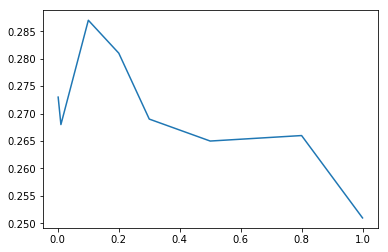

In [110]:
# 步长调参
w = np.zeros((10,3072))
b = np.zeros((10,1))
rateset = [1,0.8,0.5,0.3,0.2,0.1,0.01,0.001]
iteration = 5000
acc = []
for rate in rateset:
    p = Softmax(w,b)
    p.train(train_set,train_labels,rate,iteration,batch=30)
    val_pred = p.predict(val_set)
    count = np.sum((val_pred == val_labels))
    acc.append(count / len(val_labels))
    print('rate:%s\taccuracy in val:\t%s / %s == %s' % (rate,count,len(val_labels),count / len(val_labels)))

plt.figure()
plt.plot(rateset,acc)
plt.show()


iter:1000	accuracy in val:	220 / 1000 == 0.22
iter:2000	accuracy in val:	238 / 1000 == 0.238
iter:3000	accuracy in val:	309 / 1000 == 0.309
iter:4000	accuracy in val:	272 / 1000 == 0.272
iter:5000	accuracy in val:	151 / 1000 == 0.151
iter:6000	accuracy in val:	237 / 1000 == 0.237
iter:7000	accuracy in val:	222 / 1000 == 0.222
iter:8000	accuracy in val:	272 / 1000 == 0.272
iter:9000	accuracy in val:	254 / 1000 == 0.254
iter:10000	accuracy in val:	218 / 1000 == 0.218
iter:11000	accuracy in val:	253 / 1000 == 0.253
iter:12000	accuracy in val:	225 / 1000 == 0.225
iter:13000	accuracy in val:	302 / 1000 == 0.302
iter:14000	accuracy in val:	221 / 1000 == 0.221
iter:15000	accuracy in val:	284 / 1000 == 0.284
iter:16000	accuracy in val:	297 / 1000 == 0.297
iter:17000	accuracy in val:	299 / 1000 == 0.299
iter:18000	accuracy in val:	242 / 1000 == 0.242
iter:19000	accuracy in val:	277 / 1000 == 0.277


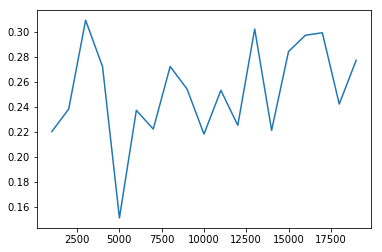

In [115]:
# 迭代次数调参
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.1
iterset = range(1000,20000,1000)

acc = []
for iteration in iterset:
    p = Softmax(w,b)
    p.train(train_set,train_labels,rate,iteration,batch=30)
    val_pred = p.predict(val_set)
    count = np.sum((val_pred == val_labels))
    acc.append(count / len(val_labels))
    print('iter:%s\taccuracy in val:\t%s / %s == %s' % (iteration,count,len(val_labels),count / len(val_labels)))

plt.figure()
plt.plot(iterset,acc)
plt.show()


## 接下来我们看训练之后得到的权重函数的图像是什么样子的

In [117]:
# 参数初始化
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.5
iteration = 2000

p = Softmax(w,b)
p.train(train_set,train_labels,rate,iteration,batch=100)
val_pred = p.predict(val_set)
count = np.sum((val_pred == val_labels))
print('accuracy in val:\t%s / %s == %s' % (count,len(val_labels),count / len(val_labels)))

accuracy in val:	298 / 1000 == 0.298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


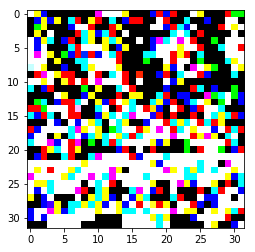

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


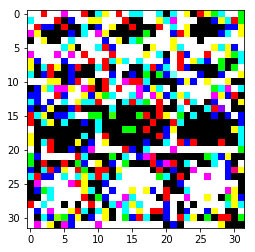

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


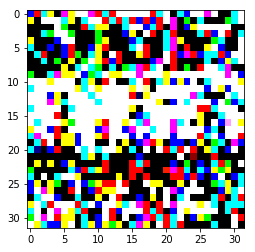

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


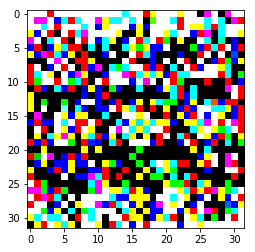

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


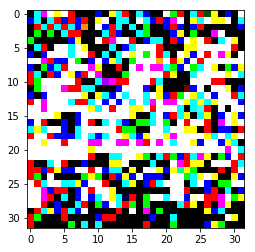

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


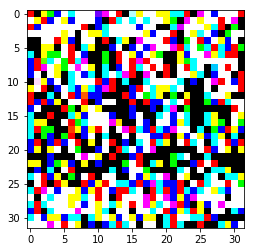

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


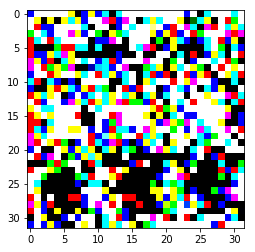

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


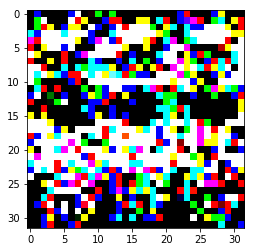

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


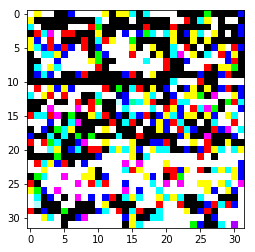

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


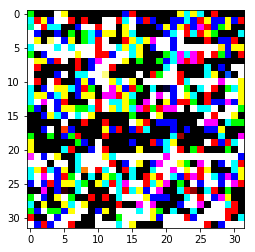

In [124]:
# 观察参数 w 的图像，失败
weight,bias = p.weight()
weight = weight.reshape(10,32,32,3)
for i in range(10):
    plt.imshow(weight[i,:,:,:])
    plt.show()